#Portfolio Optimization with Linear Programming
By Thomas Wiecki

Notebook released under the Creative Commons Attribution 4.0 License.

---


## Introduction
Given a set of securities that we're considering including in our portfolio, we'd like to pick a combination of them which maximizes returns while minimizing risk. In this notebook, we'll be using an alternative definition of risk (that is, not standard deviation) which allows us to formulate portfolio optimization as a linear program, according to the method developed by Professor Robert Vanderbei.

As usual, let's start by importing a few modules which we need later. We'll use the LP solver in `cvxopt` to find the return-maximizing portfolio subject to some linear inequalities.

## Simulations

In [355]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers, matrix
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

Assume that we have 4 assets, each with a return series of length 1000. We can use `numpy.random.randn` to sample returns from a normal distribution.

In [228]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

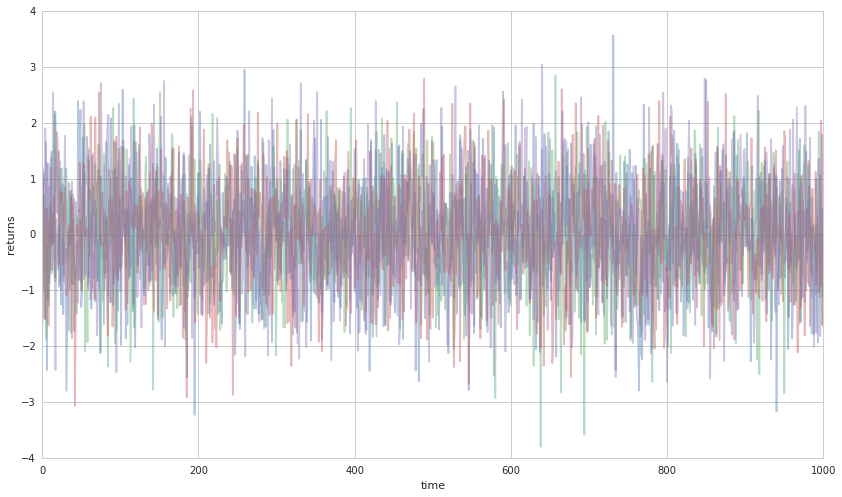

In [229]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time');
plt.ylabel('returns');

We can create different portfolios by including more or less of each asset. We will give the assets weights to represent the composition of our portfolio. The weights for all the assets must sum to one. To generate a random portfolio, we need to generate random weights:

In [289]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.39554701  0.16250763  0.12883616  0.3131092 ]
[ 0.25620569  0.15066985  0.34925393  0.24387053]


In order to compare risks and returns across different possible portfolios, we'll generate random ones and compute the mean return and the average absolute deviation for each. Unlike in the standard deviation picture of volatility, where we square the difference between the mean return and the actual return, here we are taking the absolute value of that difference. This will allow us to have only linear constraints on what our portfolio can be, and no quadratic ones.

In [290]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    wr = np.asmatrix(w*returns)
    
    mu = w * p.T
        
    dist = [abs(mu - x) for x in returns.T * w.T]
    risk = sum(dist)/len(dist)
    
    
    # This recursion reduces outliers to keep plots pretty
    if risk > 1:
        return random_portfolio(returns)
    return mu, risk

The formula we are using for risk here is
$$\frac{1}{T} \sum_{t=1}^T \lvert return(t) - \mu \rvert$$
where the return on the portfolio is the weighted sum of the returns on the included assets.

Let's generate the mean returns and volatility for 500 random portfolios:

In [292]:
n_portfolios = 500
means, risks = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

Just like with the standard deviation formula for risk in regular Markowitz optimization, the means and returns of these portfolios form the characteristic parabolic shape called the ‘Markowitz bullet‘, whose upper boundary is called the 'efficient frontier'. The efficient frontier gives the highest possible return  at a given volatility, and conversely the lowest possible volatility at a given return.

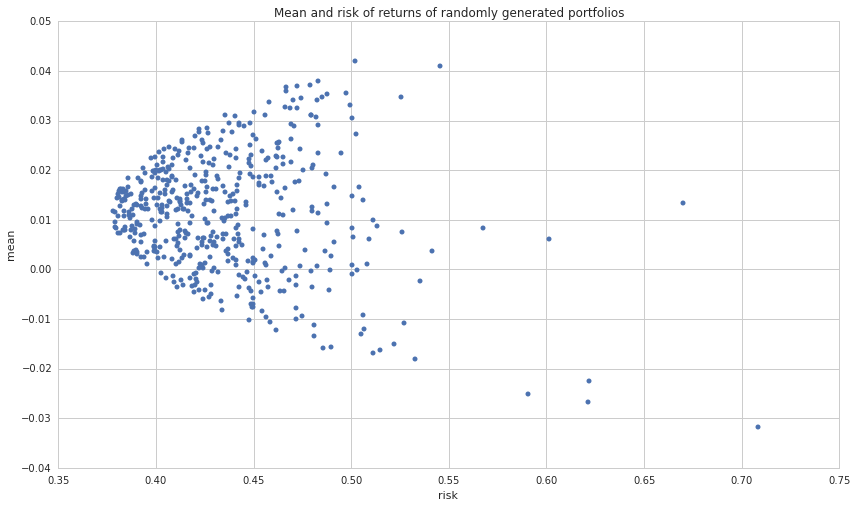

In [293]:
plt.plot(risks, means, 'o', markersize=5)
plt.xlabel('risk')
plt.ylabel('mean')
plt.title('Mean and risk of returns of randomly generated portfolios');

## Linear Markowitz optimization and the Efficient Frontier

We can solve for the efficient frontier by using an LP solver, which finds the values for our variables that minimize a given quantity (in our case, the negative expected return) subject to some inequalities of the form linear-combination-of-variables $\leq$ constant (our constraints are: risk is at most a given value, weights sum to 1, and weights are nonnegative). Note that there is no objectively best portfolio, only one which has the best returns for a given maximum risk tolerance, so we must specify this in the variable `maxrisk`. The function below will find the weights for the best portfolio based on the historical mean and historical risk of the assets.

Using `solvers.lp()` takes a bit of work. Mathematically, the inequalities we are using are
$$risk = \frac{1}{T} \sum_{t=1}^T \left| \sum_j x_j (return_j(t) - \mu_j) \right| \leq maxrisk$$
where $j$ runs over the different assets, $x_j$ is the weight of asset $j$, and $\mu_j$ is the mean return of asset $j$;
$$\sum_j x_j \leq 1$$
$$-\sum_j x_j \leq -1$$
i.e. the sum of the weights is 1; and
$$x_j \geq 0 \, \text{ for all } j.$$
Because absolute values are not allowed in a linear program, we introduce variables $y_t = \left| \sum_j x_j (return_j(t) - \mu_j) \right|$, which we relax to the pair of inequalities $-y_t \leq \sum_j x_j (return_j(t) - \mu_j) \leq y_t$. This allows $y_t$ to be larger than $\left| \sum_j x_j (return_j(t) - \mu_j) \right|$, but that's okay as we are still constrained by $\frac{1}{T} \sum_{t=1}^T y_t \leq maxrisk$.

We feed these inequalities to our solver as follows: `goal` contains the coefficients of our decision variables, the $x$s and the $y$s, in the quantity we want to maximize; `RHS` contains the constants on the right-hand sides of the inequalities; and `LHS` contains the coefficients of our decision variables on the left-hand sides the inequalities, in the format [[coeff. of var1 in eq1, coeff. of var1 in eq2, ...], [coeff. of var2 in eq2, ...], ...].

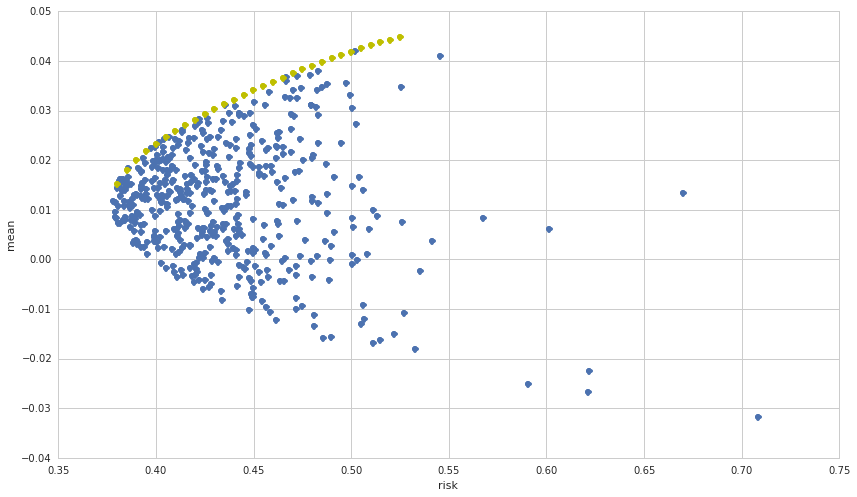

In [302]:
def optimal_portfolio(returns, maxrisk):
    '''
    Returns the weights, return, and risk for the return-maximizing portfolio
    subject to a cap on the risk.
    '''
    
    returns = np.asarray(returns)
    n = len(returns)
    time = len(returns[0])
    tot = time + n
    
    # Helper arrays will make assembling LHS easier
    y_indic = [[-1 if j == i else 0 for j in xrange(tot)] for i in xrange(n, tot)]
    x_indic = [[-1 if j == i else 0 for j in xrange(tot)] for i in xrange(n)]
    means = np.mean(returns, axis=1)
    ydef = np.asarray([[returns[i][j]-means[i] if i<n else 0 for i in xrange(tot)] for j in xrange(time)])
    
    # Want to maximize expected returns, which depend on weights*unweighted returns and not on dummy y_t's
    goal = matrix((-1*means).tolist() + [0]*time)
    
    # Linear program coefficients
    RHS = matrix([0]*(2*time + tot) + [maxrisk, 1, -1])
    LHS = (matrix((ydef + y_indic).tolist() + (-1*ydef + y_indic).tolist() + x_indic + y_indic +
               [[0 if j < n else float(1)/time for j in xrange(tot)]] +
               [[1 if j < n else 0 for j in xrange(tot)]] + [[-1 if j < n else 0 for j in xrange(tot)]])).T
    
    sol = solvers.lp(goal, LHS, RHS)
    if sol['status'] == 'primal infeasible' or sol['status'] == 'dual infeasible':
        return None, None, None
    
    # Compute return and risk for the portfolio given by the solver
    w = np.asmatrix((np.array(sol['x'][:n]))).T
    wr = np.asmatrix(w*returns)
    mu = w * np.asmatrix(means).T
    dist = [abs(mu - x) for x in returns.T * w.T]
    risk = sum(dist)/len(dist)
    
    return w.T, mu, risk

# Plot for visualization
plt.plot(risks, means, 'o')
plt.ylabel('mean')
plt.xlabel('risk');
  
for i in range(30):
    cap = .525 - .005*i
    _, mean, risk = optimal_portfolio(return_vec, cap)
    if mean:
        plt.plot(risk, mean, 'y-o');
    else:
        print 'No portfolio with risk cap ' + str(cap) + ' was found.'
        break

In yellow you can see the optimal portfolios for each of the desired risks. We also can find out the weights necessary to achieve these portfolios; for instance, here are the weights for the optimal portfolio of the ones whose risk is at most 0.38:

In [301]:
print weights

[[ 0.01607007]
 [ 0.23034698]
 [ 0.24786915]
 [ 0.5057138 ]]


## Backtesting on real market data
Now that we see how linear portfolio optimization works, we can create an algorithm in [`zipline`](http://github.com/quantopian/zipline) -- the open-source backtester that powers [Quantopian](https://www.quantopian.com) -- which uses this optimization to rebalance an actual portfolio day by day.

First we load some historical data using `get_pricing()`.

In [369]:
assets = ['XLU', 'XLB', 'XLI', 'XLV', 'XLF', 'XLE', 'MDY', 'XLK', 'XLY', 'XLP', 'QQQ', 'SPY']
data = get_pricing(assets, start_date='2010-01-04', end_date='2015-02-12')

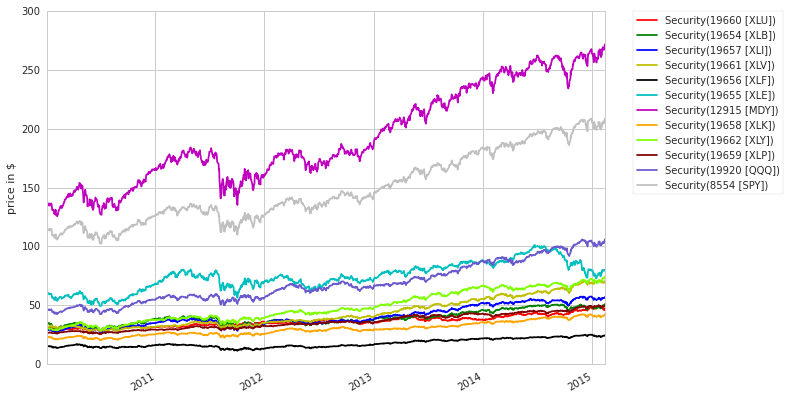

In [370]:
data.loc['price', :, :].plot(figsize=(10,7), colors=['r', 'g', 'b', 'y', 'k', 'c', 'm', 'orange',
                                                     'chartreuse', 'maroon', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('price in $');

For now, let's just consider the annualized returns, and compare the performances of random portfolios and the individual assets with the efficient frontier.

In [330]:
rreturns = (data.loc['price', :, :]).pct_change()[1:] # let's not reuse variable names from our simulation
rreturns = np.asarray(rreturns).T

# Generates and computes means and risks for random portfolios
n_portfolios = 500
rmeans, rrisks = np.column_stack([
    random_portfolio(rreturns) 
    for _ in xrange(n_portfolios)
])

XLU | XLB | XLI | XLV | XLF | XLE | MDY | XLK | XLY | XLP | QQQ | SPY || Reward | Risk
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.00077 0.0079
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.00077 0.0079
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.00077 0.0079
0.000 0.000 0.000 0.026 0.000 0.000 0.000 0.000 0.974 0.000 0.000 0.000 0.00076 0.0078
0.000 0.000 0.000 0.079 0.000 0.000 0.000 0.000 0.921 0.000 0.000 0.000 0.00076 0.0077
0.000 0.000 0.000 0.135 0.000 0.000 0.000 0.000 0.865 0.000 0.000 0.000 0.00075 0.0075
0.000 0.000 0.000 0.197 0.000 0.000 0.000 0.000 0.803 0.000 0.000 0.000 0.00075 0.0074
0.000 0.000 0.000 0.265 0.000 0.000 0.000 0.000 0.735 0.000 0.000 0.000 0.00074 0.0072
0.000 0.000 0.000 0.341 0.000 0.000 0.000 0.000 0.659 0.000 0.000 0.000 0.00073 0.0071
0.000 0.000 0.000 0.431 0.000 0.000 0.000 0.000 0.569 0.000 0.000 0.000 0.00072 0.0069
0.000 0.000 0.000 0.510 0.000 0.000 0.000 0

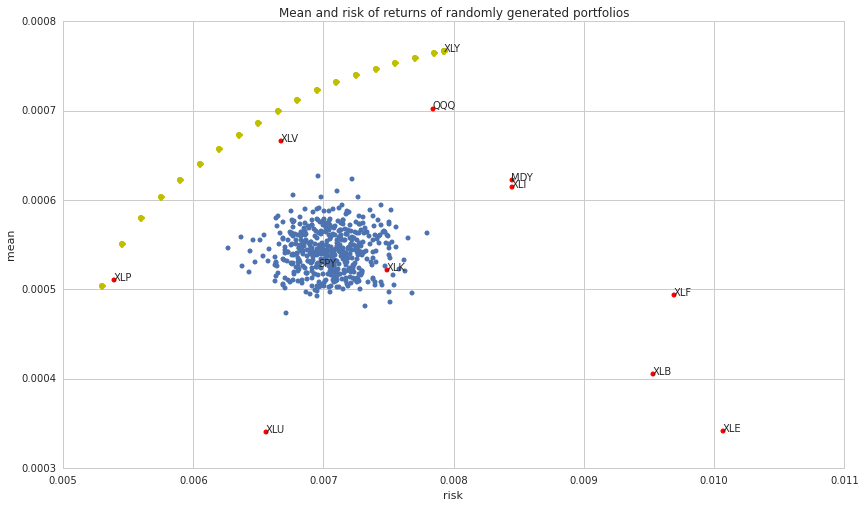

In [371]:
fig, ax = plt.subplots()

# Compute and plot means and risks for each of the individual assets
for i in range(12):
    mu = np.mean(rreturns[i,:])
    dist = [abs(mu - x) for x in rreturns[i,:]]
    risk = sum(dist)/len(dist)
    
    ax.plot(risk, mu, 'r-o', markersize = 5)
    ax.annotate(assets[i], (risk, mu))
    
# Sketch out the efficient froniter and print the weights used to achieve efficient portfolios
print ' | '.join(assets), '|| Reward | Risk'
for i in range(21):
    weights, mean, risk = optimal_portfolio(rreturns, (i/20.0)*0.0053 + (1-i/20.0)*0.0083)
    plt.plot(risk, mean, 'y-o');
    print ' '.join(map(lambda x: "%.3f" %x, weights)), "%.5f" %mean[0], "%.4f" %risk[0]
    
plt.plot(rrisks, rmeans, 'o', markersize=5)
plt.xlabel('risk')
plt.ylabel('mean')
plt.title('Mean and risk of returns of randomly generated portfolios');

The efficient frontier has the same parabolic shape as before, and all of the possible portfolios are bounded above and on the left by it. However, because of the large number of securities, our random portfolios do not fill out the bullet -- it is too unlikely to randomly generate a portfolio consisting mostly of XLP, for instance, and next to none of the other 11 assets.

Next, we'll create a `zipline` algorithm by defining two functions -- `initialize()` which is called once before the simulation starts, and `handle_data()` which is called for every trading bar. We then instantiate the algorithm object. It will tell us how to rebalance our portfolio each trading day.

If you are confused about the syntax of `zipline`, check out the [tutorial](http://nbviewer.ipython.org/github/quantopian/zipline/blob/master/docs/tutorial.ipynb).

[2015-06-04 22:50] INFO: Performance: Simulated 1287 trading days out of 1287.
[2015-06-04 22:50] INFO: Performance: first open: 2010-01-04 14:31:00+00:00
[2015-06-04 22:50] INFO: Performance: last close: 2015-02-12 21:00:00+00:00


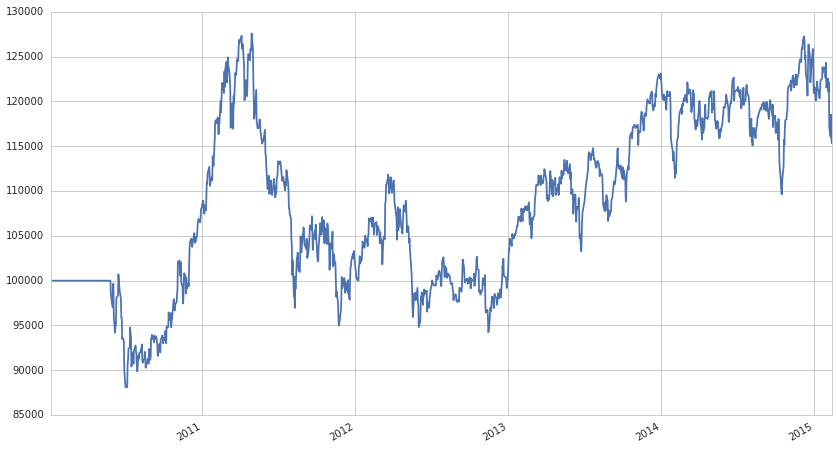

In [374]:
import zipline
from zipline.api import (add_history, 
                         history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Register history container to keep a window of the last 100 prices.
    add_history(100, '1d', 'price')
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = history(100, '1d', 'price').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform linear portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T, .04)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data.swapaxes(2, 0, 1))
results.portfolio_value.plot();

## Next steps

* Clone this notebook in the [Quantopian Research Platform](http://blog.quantopian.com/quantopian-research-your-backtesting-data-meets-ipython-notebook/) and run it on your own to see if you can enhance the performance. You can also see how changing the `maxrisk` parameter changes the performance.
* You can also download just the notebook for use in your own environment [here]().
* We are currently in the process of adding `cvxopt` to the Quantopian backtester -- stay tuned!